In [74]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
import numpy as np
from enum import Enum

In [75]:
epsilon = 1.4e-4 #fiat price per Wh
def R(t): #hash rate which can be bought for 1$
    return 42. 
def P(t): #power consumption
    return 42. 
def B(t): # number of btc to be mined per day
    if t < 853: #todo properly
        return 72.
    else:
        return 36.
def p(t): #current price
    if t == 0:
        return 0.0649
    else:
        return 42. #todo find out how p(t) is determined

In [76]:
def rtot(t): #hashing capability of whole population of miners at time t
    return sum(miner_.r(t) for miner_ in miners)

In [77]:
class Order:
    class Kind(Enum):
        BUY = 1
        SELL = 2
    def __init__(self, kind, amount, limit_price, time,  t_expiration, agent):
        self.agent = agent
        self.kind = kind
        self.amount = amount #sell: in btc ,  buy: in $
        self.residual = amount
        self.t_expiration = t_expiration
        self.time = time
        self.limit_price=limit_price # $ per btc


In [78]:
class Exchange: #TODO maybe move orderbook to its own class
    def __init__(self):
        self.orderbook = dict(zip(list(Order.Kind), [list() for _ in range(len(Order.Kind))]))
        # access as orderbook[Order.Kind.BUY],  orderbook[Order.Kind.SELL]
    
    def match(self, buy, sell): #todo: move to order class
        return (sell.limit_price <= buy.limit_price) or (sell.limit_price==0) or (buy.limit_price ==0) 
                            # sj <= bi
    def place(self, order):
        self.orderbook[order.kind].append(order)
        self.clear()
        
    def clear(self): #process all available orders
        #first sort orders
        self.orderbook[Order.Kind.SELL].sort(key=lambda o: o.limit_price) #sort should be stable, so asc time conserved
        self.orderbook[Order.Kind.BUY].sort(key=lambda o: o.limit_price, reverse=True)

        #iterate through and match orders:      
        matching = True
        while matching and len(self.orderbook[Order.Kind.SELL]) and len(self.orderbook[Order.Kind.BUY]): #while there are orders
            buy = self.orderbook[Order.Kind.BUY][0]
            sell = self.orderbook[Order.Kind.SELL][0]
            
            if self.match(buy, sell): #see if they match
                self.process(buy, sell)
            else:
                matching = False #no more matching orders
    
    def process(self, buy, sell):
        
        #determine price of transaction pT in $ per btc
        if buy.limit_price > 0. and sell.limit_price == 0.:
            pT = min(buy.limit_price, p(t))
        elif sell.limit_price > 0. and buy.limit_price == 0.:
            pT = max(sell.limit_price, p(t))
        elif sell.limit_price == 0. and buy.limit_price == 0.:
            pT = p(t)
        else: # buy.limit_price > 0 and sell.limit_price > 0
            pT = 0.5 * (buy.limit_price + sell.limit_price)
            
        #determine amount of transaction
        amount = min(sell.amount, buy.amount / pT) # in bitcoin
        
        #exchange currency
        sell.agent.b -= amount
        buy.agent.b += amount
        sell.agent.c -= amount * pT
        buy.agent.c += amount * pT    
        
        #set residual
        sell.residual -= amount
        buy.residual -= amount * pT
        
        #update price:
        #todo 
        
        #remove empty orders
        if sell.residual <= 1e-14: # ==0 ?
            self.orderbook[Order.Kind.SELL].remove(sell)
        if buy.residual <= 1e-14: # ==0 ?
            self.orderbook[Order.Kind.BUY].remove(buy)
    
    def remove_old_orders(self):
        for kind in list(Order.Kind):
            book = self.orderbook[kind]
            for order in book: #todo do this in one nice line :D
                if  t - order.time > order.t_expiration:
                    book.remove(order)
                


In [79]:
coinbase = Exchange()

In [80]:
class CryptoCurrencyAgent(Agent):
    """An agent"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.c = 1000. #fiat cash
        self.b = 1. #cryptocurrency
        self.te = 0. #entry time
        self.exchange = coinbase
    
    @property 
    def cb(self): #$ not in buy orders, todo do this in a more efficient way
        return sum(order.amount for order in self.exchange.orderbook[Order.Kind.SELL] if order.agent==self ) 
    @property    
    def bs(self): #btc not in buy orders
        return sum(order.amount for order in self.exchange.orderbook[Order.Kind.BUY] if order.agent==self) #TODO dont copypaste

    def placeorder(self, order):
        self.exchange.place(order)

In [81]:
class Miner(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gamma1_ = [0.5] #percentage of cash allocated to buy
        if t==0:
            self.tID = random.choice(range(61)) #take decision to buy in the first 60 days uniform distr, todo use np
        else:
            self.update_tID() #time when to buy new mining hardware
    
    def update_tID(self):
        mu, sigma = 0, 6.
        self.tID = t + round(60 + np.random.normal(mu, sigma))
    def gamma(self,t):
        return 0.5 * self.gamma1(t)
    def gamma1(self,t):
        return self.gamma1_[t-te]
    
    def ru(self, t): #hardware capability of units bought
        if t==te:
            return gamma1(t) * c(t) * R(t)
        else:
            return ( gamma1(t) * c(t) + gamma(t) * b(t)*p(t) )*R(t)
    def r(self, t): #hashing capability
        return sum( self.ru(s) for s in range(self.te, t) )
    def e(self, t): #total elextricity cost
        return sum( epsilon * P(s) * self.r(s) * 24 for s in range(self.te, t) )

    def b(self, t):
        return self.r(t)/rtot(t) * B(t)
    
    def buy_hardware(self):
        #todo
        #buy hardware
        #divest hardware older than one year
        None
    def step(self):
        if t==self.tID:
            self.buy_hardware()
            #todo
            #set next time when to buy
            self.update_tID()
        #todo
        None

In [82]:

class Chartist(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        

In [83]:
class Trader(CryptoCurrencyAgent):
    """A Miner"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.tradeprobability = 0.5
    def step(self):
        if (random.random() < self.tradeprobability):
            beta = np.random.lognormal(mean=0.25, sigma=0.2)
            #mu, sigma = 1, 0.1 # TODO correct values
            mu, sigma = 1, 0.5 # TODO correct values

            N = np.random.normal(mu, sigma)
            kind = random.choice(list(Order.Kind))
            if kind == Order.Kind.SELL:
                amount = self.cb * beta / p(t) #sa
                limit = p(t) / N
            else: #BUY
                amount = self.bs * beta #ba
                limit = p(t) * N
                
            #kind, amount, limit_price, time,  t_expiration, agent
            self.placeorder(Order(kind ,amount, limit, t, 10, self) )  



In [84]:
class CryptoCurrencyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        #for i in range(self.num_agents):
        #    a = Miner(i, self)
        #    self.schedule.add(a)
        for i in range(self.num_agents):
            a = Trader(i, self)
            self.schedule.add(a)
    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [85]:
model = CryptoCurrencyModel(100)

In [86]:
t=0
for i in range(1000):
    t += 1
    coinbase.remove_old_orders() #todo move this into step
    model.step()

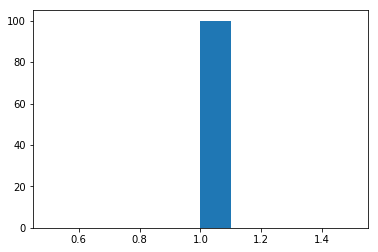

In [87]:
import matplotlib.pyplot as plt
agent_btc = [a.b for a in model.schedule.agents]
plt.hist(agent_btc)
plt.show()